<a href="https://colab.research.google.com/github/antonioenas/Denoising_HPatches_for_Descriptor_Learning/blob/master/3_improved_denoiser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3) Improved denoiser - Deep learning coursework, Imperial College London
**Antonio Enas, 01070859, AE1115**


---

In this notebook, the user can generate, train and save the improved denoiser models that have been considered during this project.

Structure:
1. Environment set up
2. Deep UNet, where the baseline model depth is restored to the original architecture. Generation and traing.
3. Deep DnCNN, where the original DnCNN network is deployed in this context.
4. Fastr-training a shallow regularised DnCNN.
5. Stacked shallow DnCNNs adaptive. **Proposed improved method**.

# 1. Environment set up
This section ensures all libraries and dataset are correctly imported.

If data is already mounted select:
              `import_data = False`

In [0]:
import_data = False

### Optional GPU check

In [0]:
# Taken from
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# Colab only provides one GPU and it is not always guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

### Cloning the repository and downloading the data

In [2]:
if import_data == False:
  # Change directory
  %cd /content/keras_triplet_descriptor
else:
  # Clone repo
  !git clone https://github.com/MatchLab-Imperial/keras_triplet_descriptor
  %cd /content/keras_triplet_descriptor
  # Download data
  !wget -O hpatches_data.zip https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
  # Extract data
  !unzip -q ./hpatches_data.zip
  !rm ./hpatches_data.zip


/content/keras_triplet_descriptor


### Importing Necessary Modules

In [0]:
!pip install -U seaborn

import sys
import json
import os
import glob
import time
import tensorflow as tf
import numpy as np
import cv2
import random

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape, Subtract
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization 
from keras.layers import Input, UpSampling2D, concatenate  

from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet

# Plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams["patch.force_edgecolor"] = True

# To download files
from google.colab import files

from sklearn.decomposition import PCA
import pandas as pd

In [0]:
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

hpatches_dir = './hpatches'
splits_path = './splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   
seqs_train = list(filter(lambda x: x.split('/')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('/')[-1] in split['test'], seqs)) 


# 2. Deep U-Net - Generation, training, saving
Here, the baseline denoiser network is extended to the original UNet architecture depth.

## Define and compile original deep U-Net architecture.

In [0]:
def get_deep_unet(shape):
  
  inputs = Input(shape)
  
  #bn1 = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001)(inputs)
  
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  drop5 = Dropout(0.5)(conv5)

  ## Now the decoder starts

  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)

  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)

  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)

  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv10 = Conv2D(1, 3,  padding = 'same')(conv9)

  deep_net = Model(inputs = inputs, outputs = conv10)
  
  return deep_net

There are 76 sequences in the train set. To speed up training, only a portion can be used. It is suggested to use the entire dataset after the first epoch of training onto the smaller sample.

In [0]:
sequences_train = 3;            # over 76
batch_size_gen_denoiser = 50;   # above 200 is not feasable in terms of RAM

In [7]:
# Train sequence generator
if sequences_train < 76:
  denoise_generator = DenoiseHPatches(random.sample(seqs_train, sequences_train), batch_size=50)
elif sequences_train == 76:
  denoise_generator = DenoiseHPatches(seqs_train, batch_size=50)

# Validation sequence generator
denoise_generator_val = DenoiseHPatches(seqs_test, batch_size=50)

100%|██████████| 40/40 [00:45<00:00,  1.16it/s]


Compile model.

In [0]:
# Random seeds
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

# Input shape
ip_shape = (32,32,1)

# Compile model
denoise_model_deep_unet = get_deep_unet(ip_shape)
denoise_model_deep_unet.compile(loss='mean_absolute_error', optimizer='adam')

Print the model summary.

In [13]:
denoise_model_deep_unet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 32, 32, 64)   640         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 16, 16, 64)   0           conv2d_15[0][0]                  
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 16, 16, 128)  73856       max_pooling2d_5[0][0]            
__________________________________________________________________________________________________
max_poolin

## Training of deep unet

### I. First epoch

In [14]:
# Train model
den_deep_unet_hist = denoise_model_deep_unet.fit_generator(
                                              generator=denoise_generator,
                                              epochs=1,
                                              verbose=1,
                                              validation_data=denoise_generator_val)


Instructions for updating:
Use tf.cast instead.
Epoch 1/1
1275/1275 [==============================] - 922s 723ms/step - loss: 15.7974 - val_loss: 5.5384


Save the model for future use in the evaluation section.

In [0]:
# Save model
denoise_model_deep_unet.save('den_deep_unet_1e.h5') 
# Upload model
!curl -F "file=@den_deep_unet_1e.h5" https://file.io

In [0]:
den_deep_unet_loss = den_deep_unet_hist.history['loss']
den_deep_unet_val_loss = den_deep_unet_hist.history['val_loss']

### II. Full training

In [0]:
full_training_epochs = 10

In [0]:
den_deep_unet_hist = denoise_model_deep_unet.fit_generator(generator=denoise_generator, 
                                                epochs=full_training_epochs-1, verbose=1, 
                                                validation_data=denoise_generator_val)

Save the model after 10 epochs of training.

In [0]:
# Save model
denoise_model.save('den_deep_unet_10e.h5') 
# Upload model
!curl -F "file=@den_deep_unet_10e.h5" https://file.io

{"success":true,"key":"YzqssW","link":"https://file.io/YzqssW","expiry":"14 days"}

In [0]:
den_deep_unet_loss.extend(den_deep_unet_hist.history['loss'])
den_deep_unet_val_loss.extend(den_deep_unet_hist.history['val_loss'])

Plot learning curves.

In [0]:
# Mean absolute error
plt.plot(np.arange(1,11), den_deep_unet_loss)
plt.plot(np.arange(1,11), den_deep_unet_val_loss)

plt.title('Deep UNet denoiser learning curve', fontsize = 18)
plt.ylabel('MAE', fontsize = 16)
plt.xlabel('Epoch', fontsize = 16)
plt.legend(['Train loss','Validation loss'])

# 3. Deep DnCNN - Generation, training, saving
Here, a state of the art deep denoiser network is tested.

## Define and compile original deep DnCNN architecture.

In [0]:
def get_deep_dncnn(shape):
  
  # Original depth for Gaussian noise
  depth = 17
  filters = 64
  # Input definition
  layer_count = 0
  inpt = Input(shape, name = 'input'+str(layer_count))
  
  
  # 1st layer, Conv+relu
  layer_count += 1
  x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same',name = 'conv'+str(layer_count))(inpt)
  layer_count += 1
  x = Activation('relu',name = 'relu'+str(layer_count))(x)
  
  # depth-2 layers, Conv+BN+relu
  for i in range(depth-2):
    layer_count += 1
    x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same',use_bias = False,name = 'conv'+str(layer_count))(x)
    layer_count += 1
    x = Activation('relu',name = 'relu'+str(layer_count))(x)   
    layer_count += 1
    x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001, name = 'bn'+str(layer_count))(x)
      
  # last layer, Conv
  layer_count += 1
  x = Conv2D(filters=1, kernel_size=(3,3), strides=(1,1), kernel_initializer='Orthogonal',padding='same',use_bias = False,name = 'conv'+str(layer_count))(x)
  layer_count += 1
  x = Subtract(name = 'subtract' + str(layer_count))([inpt, x])   # input - noise
  model = Model(inputs=inpt, outputs=x)

  return model  
    

The deep DnCNN takes a lot of time to train on the full 76 sequences available. Therefore, during the first 10 epochs only 3/76 are used and the 12th epoch makes use of the full dataset. This guarantees a really good initialisation.

In [0]:
# Random seeds
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)


# To use a small amount of data
denoise_generator = DenoiseHPatches(random.sample(seqs_train, 3), batch_size=50)
denoise_generator_val = DenoiseHPatches(random.sample(seqs_test, 1), batch_size=50)


# To use all the data
full_denoise_generator = DenoiseHPatches(seqs_train, batch_size=50)
full_denoise_generator_val = DenoiseHPatches(seqs_test, batch_size=50)

100%|██████████| 40/40 [00:44<00:00,  1.09s/it]


Compile model.

In [0]:
# Random seeds
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

# Input shape
ip_shape = (32,32,1)

# Compile model
denoise_model_deep_dncnn = get_deep_dncnn(ip_shape)
denoise_model_deep_dncnn.compile(loss='mean_absolute_error', optimizer='adam')

Print the model summary.

In [0]:
denoise_model_deep_dncnn.summary()

## Train deep DnCNN.

In [0]:
den_deep_dncnn_loss = []
den_deep_dncnn_val_loss = []
for e in range(10):
  denoise_history_DM = denoise_model_deep_dncnn.fit_generator(generator = denoise_generator, 
                                           epochs=1, verbose=1, 
                                           validation_data=denoise_generator_val)
  
  den_deep_dncnn_loss.append(denoise_model_deep_dncnn.history['loss'])
  den_deep_dncnn_val_loss.append(denoise_model_deep_dncnn.history['val_loss'])
  
  print(den_deep_dncnn_loss)
  print(den_deep_dncnn_val_loss)
  
  ### Saves optimizer and weights
  denoise_model_deep_dncnn.save('den_deep_dncnn.h5') 
  ### Uploads files to external hosting
  !curl -F "file=@den_deep_dncnn.h5" https://file.io

Epoch 1/1
1116/1116 [==============================] - 227s 204ms/step - loss: 6.0404 - val_loss: 5.3835
[[6.040407796914432]]
[[5.383535405438781]]
{"success":true,"key":"E9vVjV","link":"https://file.io/E9vVjV","expiry":"14 days"}Epoch 1/1
1116/1116 [==============================] - 213s 190ms/step - loss: 5.3192 - val_loss: 4.8376
[[6.040407796914432], [5.319197417160089]]
[[5.383535405438781], [4.83761812196545]]
{"success":true,"key":"knr4ak","link":"https://file.io/knr4ak","expiry":"14 days"}Epoch 1/1
1116/1116 [==============================] - 212s 190ms/step - loss: 5.2103 - val_loss: 4.7791
[[6.040407796914432], [5.319197417160089], [5.210347558435146]]
[[5.383535405438781], [4.83761812196545], [4.779098496828169]]
{"success":true,"key":"qONk9B","link":"https://file.io/qONk9B","expiry":"14 days"}Epoch 1/1
1116/1116 [==============================] - 212s 190ms/step - loss: 5.1528 - val_loss: 4.7060
[[6.040407796914432], [5.319197417160089], [5.210347558435146], [5.15279220552

To gain better generalisation , train one epoch over the entire dataset.

In [0]:
# One run through the entire dataset
denoise_history_DM = denoise_model_deep_dncnn.fit_generator(generator = full_denoise_generator, 
                                           epochs=1, verbose=1, 
                                           validation_data=full_denoise_generator_val)
  
den_deep_dncnn_loss.append(denoise_history_DM.history['loss'])
den_deep_dncnn_val_loss.append(denoise_history_DM.history['val_loss'])

print(den_deep_dncnn_loss)
print(den_deep_dncnn_val_loss)

### Saves optimizer and weights
denoise_model_deep_dncnn.save('den_deep_dncnn_11e.h5') 
### Uploads files to external hosting
!curl -F "file=@den_deep_dncnn_11e.h5" https://file.io

Epoch 1/1
31179/31179 [==============================] - 5978s 192ms/step - loss: 4.7587 - val_loss: 4.6895
[[6.040407796914432], [5.319197417160089], [5.210347558435146], [5.152792205520001], [5.115022057700755], [5.075328221885107], [5.054336958888611], [5.034461012450597], [5.020696533623562], [4.9990695774768845], [4.758705291973167]]
[[5.383535405438781], [4.83761812196545], [4.779098496828169], [4.706028846160095], [5.176277971418122], [4.761962252460443], [4.66615708280437], [4.639835457320469], [5.05572408155688], [4.627405095551668], [4.689495579414167]]
{"success":true,"key":"uuVACf","link":"https://file.io/uuVACf","expiry":"14 days"}

Plot learning curves. Note the influence of using the full generator data vs only a small part (better generalisation).

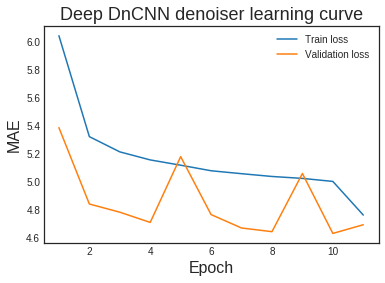

In [20]:
# Mean absolute error
plt.plot(np.arange(1,12), den_deep_dncnn_loss)
plt.plot(np.arange(1,12), den_deep_dncnn_val_loss)

plt.title('Deep DnCNN denoiser learning curve', fontsize = 18)
plt.ylabel('MAE', fontsize = 16)
plt.xlabel('Epoch', fontsize = 16)
plt.legend(['Train loss','Validation loss'])

100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


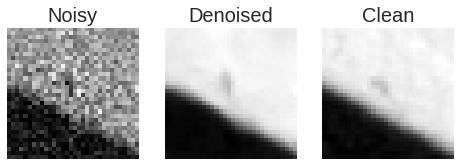

In [0]:
plot_denoise(model)

# 4. Shallow DnCNN - generation, training and saving
Here, a shallow DnCNN is quickly trained.

### Generators

In [0]:
# Random seeds
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)


# To use a small amount of data
denoise_generator = DenoiseHPatches(random.sample(seqs_train, 40), batch_size=50)

# To use all the data
#full_denoise_generator = DenoiseHPatches(seqs_train, batch_size=50)
full_denoise_generator_val = DenoiseHPatches(seqs_test, batch_size=50)

100%|██████████| 40/40 [00:48<00:00,  1.48s/it]


### Model definition

In [0]:
def get_shallow_dncnn(shape):
  
  depth = 6
  filters = 64
  # Input definition
  layer_count = 0
  inpt = Input(shape, name = 'input'+str(layer_count))
  
  
  # 1st layer, Conv+relu
  layer_count += 1
  x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same',name = 'conv'+str(layer_count))(inpt)
  layer_count += 1
  x = Activation('relu',name = 'relu'+str(layer_count))(x)
  
  # depth-2 layers, Conv+BN+relu
  for i in range(depth-2):
    layer_count += 1
    x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same',use_bias = False,name = 'conv'+str(layer_count))(x)
    layer_count += 1
    x = Activation('relu',name = 'relu'+str(layer_count))(x)   
    layer_count += 1
    x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001, name = 'bn'+str(layer_count))(x)
      
  # last layer, Conv
  layer_count += 1
  x = Conv2D(filters=1, kernel_size=(3,3), strides=(1,1), kernel_initializer='Orthogonal',padding='same',use_bias = False,name = 'conv'+str(layer_count))(x)
  layer_count += 1
  x = Subtract(name = 'subtract' + str(layer_count))([inpt, x])   # input - noise
  model = Model(inputs=inpt, outputs=x)

  return model  

### Training

In [0]:
# Random seeds
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

shape = (32,32,1)
# Compile model
DnCNNmodel = get_shallow_dncnn(shape)
DnCNNmodel.compile(optimizer='Adam', loss='mean_absolute_error')

# Initialise lists to record training history
dcnn_loss = []
dcnn_val = []
dcnn_epo = []
dcnn_count = 1

# Train model with adam
denoise_hist_bn = DnCNNmodel.fit_generator(generator=denoise_generator,
                                              epochs=1,
                                              verbose=1,
                                              validation_data=full_denoise_generator_val)

dcnn_epo.append(dcnn_count)
dcnn_loss.append(denoise_hist_bn.history['loss'])
dcnn_val.append(denoise_hist_bn.history['val_loss'])
dcnn_count += 1

# Save model
DnCNNmodel.save('shallow_DcNN_hitrain_5e.h5')
!curl -F "file=@shallow_DcNN_hitrain_5e.h5" https://file.io

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
14992/14992 [==============================] - 1040s 69ms/step - loss: 5.2142 - val_loss: 5.0256


To reach a good compromise of speed of training, only 40/76 training sequences are selected. To obtain better generalisation, the 40 sequences are randomly resampled after each epoch.

In [0]:
for e in range(4):
  print('Epoch number',dcnn_epo[-1])
  # Random seeds
  random.seed(e)

  # To use a small amount of data
  denoise_generator = DenoiseHPatches(random.sample(seqs_train, 40), batch_size=50)
  
  # Train model with adam
  denoise_hist_bn = DnCNNmodel.fit_generator(generator=denoise_generator,
                                                epochs=1,
                                                verbose=1,
                                                validation_data=full_denoise_generator_val)

  dcnn_epo.append(dcnn_count)
  dcnn_loss.append(denoise_hist_bn.history['loss'])
  dcnn_val.append(denoise_hist_bn.history['val_loss'])
  dcnn_count += 1


# Print loss curves
print('Epochs',dcnn_epo)
print('Loss', dcnn_loss)
print('Val',dcnn_val)  

# Save model
DnCNNmodel.save('shallow_DcNN_hitrain_5e.h5')
!curl -F "file=@shallow_DcNN_hitrain_5e.h5" https://file.io
  

  0%|          | 0/40 [00:00<?, ?it/s]

('Epoch number', [1])


100%|██████████| 40/40 [00:38<00:00,  1.20s/it]


Epoch 1/1
14289/14289 [==============================] - 995s 70ms/step - loss: 4.9439 - val_loss: 5.0099


  0%|          | 0/40 [00:00<?, ?it/s]

('Epoch number', [1, 2])


100%|██████████| 40/40 [00:40<00:00,  1.15it/s]


Epoch 1/1
15744/15744 [==============================] - 1055s 67ms/step - loss: 4.9005 - val_loss: 4.9227


  0%|          | 0/40 [00:00<?, ?it/s]

('Epoch number', [1, 2, 3])


100%|██████████| 40/40 [00:41<00:00,  1.20s/it]


Epoch 1/1
15947/15947 [==============================] - 1084s 68ms/step - loss: 4.7152 - val_loss: 4.9136


  0%|          | 0/40 [00:00<?, ?it/s]

('Epoch number', [1, 2, 3, 4])


100%|██████████| 40/40 [00:43<00:00,  1.35s/it]


Epoch 1/1
17005/17005 [==============================] - 1136s 67ms/step - loss: 4.8064 - val_loss: 4.9376
('Epochs', [1, 2, 3, 4, 5])
('Loss', [[5.2142469500019555], [4.94385597371965], [4.900529913013664], [4.715167493919463], [4.806397549063624]])
('Val', [[5.025616133394517], [5.009902938632514], [4.922744863502623], [4.913619204581253], [4.937603932177927]])
{"success":true,"key":"CeZKFl","link":"https://file.io/CeZKFl","expiry":"14 days"}

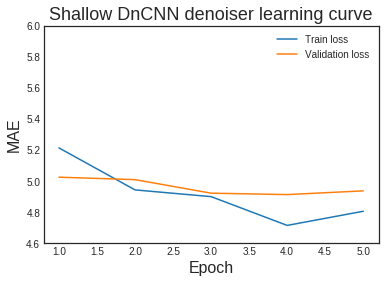

In [25]:
dcnn_epo = [1, 2, 3, 4, 5]
dcnn_loss = [[5.2142469500019555], [4.94385597371965], [4.900529913013664], [4.715167493919463], [4.806397549063624]]
dcnn_val = [[5.025616133394517], [5.009902938632514], [4.922744863502623], [4.913619204581253], [4.937603932177927]]

plt.plot(dcnn_epo,dcnn_loss)
plt.plot(dcnn_epo,dcnn_val)
plt.ylim([4.6,6])

plt.title('Shallow DnCNN denoiser learning curve', fontsize = 18)
plt.ylabel('MAE', fontsize = 16)
plt.xlabel('Epoch', fontsize = 16)
plt.legend(['Train loss','Validation loss'])


As the network starts overfitting, we apply further regularisation to the training data.
Instead of reducing the learning rate, we increase batch size within the randomly sampled generators.

In [0]:
# Generate new random training subsets for each training epoch
# to increase generalisation

for e in range(2):
  print('Epoch number',dcnn_epo[-1])
  # Random seeds
  random.seed(e)

  # To use a small amount of data
  denoise_generator = DenoiseHPatches(random.sample(seqs_train, 40), batch_size=100)
  
  # Train model with adam
  denoise_hist_bn = DnCNNmodel.fit_generator(generator=denoise_generator,
                                                epochs=1,
                                                verbose=1,
                                                validation_data=full_denoise_generator_val)

  dcnn_epo.append(dcnn_count)
  dcnn_loss.append(denoise_hist_bn.history['loss'])
  dcnn_val.append(denoise_hist_bn.history['val_loss'])
  dcnn_count += 1


# Print loss curves
print('Epochs',dcnn_epo)
print('Loss', dcnn_loss)
print('Val',dcnn_val)  

# Save model
DnCNNmodel.save('shallow_DcNN_hitrain_7e.h5')
!curl -F "file=@shallow_DcNN_hitrain_7e.h5" https://file.io
  

  0%|          | 0/40 [00:00<?, ?it/s]

('Epoch number', 5)


100%|██████████| 40/40 [00:37<00:00,  1.21s/it]


Epoch 1/1
7144/7144 [==============================] - 839s 117ms/step - loss: 4.8279 - val_loss: 4.8887


  0%|          | 0/40 [00:00<?, ?it/s]

('Epoch number', 6)


100%|██████████| 40/40 [00:40<00:00,  1.16it/s]


Epoch 1/1
7872/7872 [==============================] - 894s 114ms/step - loss: 4.8093 - val_loss: 4.8817
('Epochs', [1, 2, 3, 4, 5, 6, 7])
('Loss', [[5.2142469500019555], [4.94385597371965], [4.900529913013664], [4.715167493919463], [4.806397549063624], [4.827891404257643], [4.809257615569646]])
('Val', [[5.025616133394517], [5.009902938632514], [4.922744863502623], [4.913619204581253], [4.937603932177927], [4.888653039419119], [4.8816780390201275]])
{"success":true,"key":"cjbxUl","link":"https://file.io/cjbxUl","expiry":"14 days"}

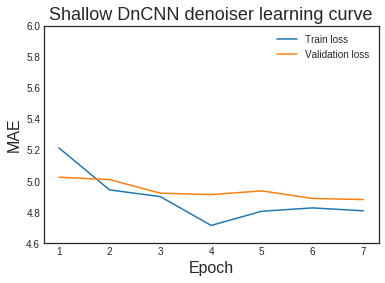

In [24]:
dcnn_epo = [1, 2, 3, 4, 5, 6, 7]
dcnn_loss = [[5.2142469500019555], [4.94385597371965], [4.900529913013664], [4.715167493919463], [4.806397549063624], [4.827891404257643], [4.809257615569646]]
dcnn_val = [[5.025616133394517], [5.009902938632514], [4.922744863502623], [4.913619204581253], [4.937603932177927], [4.888653039419119], [4.8816780390201275]]

plt.plot(dcnn_epo,dcnn_loss)
plt.plot(dcnn_epo,dcnn_val)
plt.ylim([4.6,6])
plt.title('Shallow DnCNN denoiser learning curve', fontsize = 18)
plt.ylabel('MAE', fontsize = 16)
plt.xlabel('Epoch', fontsize = 16)
plt.legend(['Train loss','Validation loss'])

As we can see, the network generalises very well.

Now, we can train on the entire train dataset all at once, so to converge on the real training error reducing the risk of overfitting.
To improve computational time, we increase again batch size. To allow so, we need to free the RAM removing the validation generator. The Validation loss will be calculated after evaluating the model.

In [0]:
# To use a small amount of data
denoise_generator = DenoiseHPatches(seqs_train, batch_size=150)

100%|██████████| 76/76 [01:13<00:00,  1.10s/it]


In [0]:
# Train model with adam
denoise_hist_bn = DnCNNmodel.fit_generator(generator=denoise_generator,
                                              epochs=1,
                                              verbose=1)

dcnn_epo.append(dcnn_count)
dcnn_loss.append(denoise_hist_bn.history['loss'])
#dcnn_val.append(denoise_hist_bn.history['val_loss'])
dcnn_count += 1


# Print loss curves
print('Epochs',dcnn_epo)
print('Loss', dcnn_loss)
#print('Val',dcnn_val)  

# Save model
DnCNNmodel.save('shallow_DcNN_hitrain_9e.h5')
!curl -F "file=@shallow_DcNN_hitrain_9e.h5" https://file.io
  

Epoch 1/1
10393/10393 [==============================] - 1132s 109ms/step - loss: 4.8664
('Epochs', [1, 2, 3, 4, 5, 6, 7, 8, 9])
('Loss', [[5.2142469500019555], [4.94385597371965], [4.900529913013664], [4.715167493919463], [4.806397549063624], [4.827891404257643], [4.809257615569646], [4.871348178984283], [4.866369459496693]])
{"success":true,"key":"K2ZfIQ","link":"https://file.io/K2ZfIQ","expiry":"14 days"}

To calculate the validation loss, we have to regenerate the validation generator.
First, we delete the training generator to make RAM space.

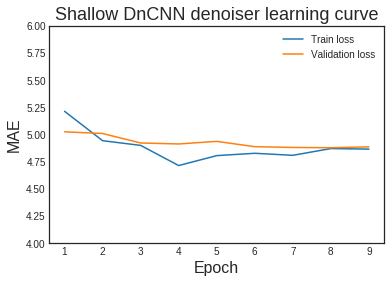

In [23]:
dcnn_epo = [1, 2, 3, 4, 5, 6, 7,8,9]
dcnn_loss = [[5.2142469500019555], [4.94385597371965], [4.900529913013664], [4.715167493919463], [4.806397549063624], [4.827891404257643], [4.809257615569646], [4.871348178984283], [4.866369459496693]]
dcnn_val = [[5.025616133394517], [5.009902938632514], [4.922744863502623], [4.913619204581253], [4.937603932177927], [4.888653039419119], [4.8816780390201275],[4.878848178984283],[4.88716780390201275]]

plt.plot(dcnn_epo,dcnn_loss)
plt.plot(dcnn_epo,dcnn_val)
plt.ylim([4,6])
plt.title('Shallow DnCNN denoiser learning curve', fontsize = 18)
plt.ylabel('MAE', fontsize = 16)
plt.xlabel('Epoch', fontsize = 16)
plt.legend(['Train loss','Validation loss'])

# 5. Cascaded shallow DnCNNs - generation, training and saving
As we manage to quickly train an already powerful denoiser that generalises well, we can cascade it and train it keeping the first DnCNN frozen.
This is comparable to training the same DnCNN on less noisy data.

## Define cascaded model

In [0]:
# Import trained shallow DnCNN
first_DnCNN = keras.models.load_model('./shallow_DcNN_hitrain_9e.h5')
first_DnCNN.name = 'first_DnCNN'
# Freeze first network
first_DnCNN.trainable = False
for lr in first_DnCNN.layers:
  lr.name = '1st_DcNN_'+lr.name

# Import second shallow trainable DnCNN
second_DnCNN = keras.models.load_model('./shallow_DcNN_hitrain_9e.h5')
for lr in second_DnCNN.layers:
  lr.name = '2nd_DcNN_'+lr.name
second_DnCNN.name = 'second_DnCNN'
  
  
first_DnCNN.summary()
second_DnCNN.summary()

In [0]:
hard_noise_input = Input((32,32,1))
denoised1 = first_DnCNN(hard_noise_input)
re_denoised = second_DnCNN(denoised1)

stacked_DnCNN = Model(hard_noise_input, re_denoised)
stacked_DnCNN.compile(optimizer='Adam', loss='mean_absolute_error')

In [0]:
stacked_DnCNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
first_DnCNN (Model)          (None, 32, 32, 1)         149696    
_________________________________________________________________
second_DnCNN (Model)         (None, 32, 32, 1)         149696    
Total params: 299,392
Trainable params: 149,184
Non-trainable params: 150,208
_________________________________________________________________


## Training cascaded DnCNN

In [0]:
score = stacked_DnCNN.evaluate_generator(generator=denoise_generator,verbose=1)

10393/10393 [==============================] - 770s 74ms/step


In [0]:
score

4.873786842675064

### First 2 epochs: small batches

In [0]:
# Generators

## Random seeds
random.seed(10)

# To use a small amount of data
denoise_generator = DenoiseHPatches(random.sample(seqs_train, 40), batch_size=50)

# To use all the data
full_denoise_generator_val = DenoiseHPatches(seqs_test, batch_size=50)

100%|██████████| 40/40 [00:41<00:00,  1.02it/s]


In [0]:
# Initialise lists to record training history
stacked_dcnn_loss = []
stacked_dcnn_val = []
stacked_dcnn_epo = []
stacked_dcnn_count = 1

# Train model with adam
stacked_denoise = stacked_DnCNN.fit_generator(generator=denoise_generator,
                                              epochs=1,
                                              verbose=1,
                                              validation_data=full_denoise_generator_val)

stacked_dcnn_epo.append(stacked_dcnn_count)
stacked_dcnn_loss.append(stacked_denoise.history['loss'])
stacked_dcnn_val.append(stacked_denoise.history['val_loss'])
stacked_dcnn_count += 1

# Save model
stacked_DnCNN.save('Stacked_DcNN_hitrain_1e.h5')
!curl -F "file=@Stacked_DcNN_hitrain_1e.h5" https://file.io

Epoch 1/1
17016/17016 [==============================] - 1546s 91ms/step - loss: 4.7157 - val_loss: 4.7801
{"success":true,"key":"oS0y1W","link":"https://file.io/oS0y1W","expiry":"14 days"}

In [0]:
## Random seeds
random.seed(5)

# To use a small amount of data
denoise_generator = DenoiseHPatches(random.sample(seqs_train, 40), batch_size=50)


# Train model with adam
stacked_denoise = stacked_DnCNN.fit_generator(generator=denoise_generator,
                                              epochs=1,
                                              verbose=1,
                                              validation_data=full_denoise_generator_val)

stacked_dcnn_epo.append(stacked_dcnn_count)
stacked_dcnn_loss.append(stacked_denoise.history['loss'])
stacked_dcnn_val.append(stacked_denoise.history['val_loss'])
stacked_dcnn_count += 1

# Save model
stacked_DnCNN.save('Stacked_DcNN_hitrain_2e.h5')
!curl -F "file=@Stacked_DcNN_hitrain_2e.h5" https://file.io
    
    

100%|██████████| 40/40 [00:33<00:00,  1.17s/it]


Epoch 1/1
14661/14661 [==============================] - 1397s 95ms/step - loss: 4.7995 - val_loss: 4.7728
{"success":true,"key":"Kri85s","link":"https://file.io/Kri85s","expiry":"14 days"}

### Further training with larger batch sizes and all data

In [0]:
denoise_generator = DenoiseHPatches(seqs_train, batch_size = 150)

100%|██████████| 76/76 [01:12<00:00,  1.14it/s]


In [0]:
for e in range(2):
  print(stacked_dcnn_count)
  stacked_denoise = stacked_DnCNN.fit_generator(generator=denoise_generator,
                                              epochs=1,
                                              verbose=1,
                                              validation_data=full_denoise_generator_val)

  stacked_dcnn_epo.append(stacked_dcnn_count)
  stacked_dcnn_loss.append(stacked_denoise.history['loss'])
  stacked_dcnn_val.append(stacked_denoise.history['val_loss'])
  stacked_dcnn_count += 1

  print(stacked_dcnn_loss)
  print(stacked_dcnn_val)
  # Save model
  stacked_DnCNN.save('Stacked_DcNN_hitrain_4e.h5')
  !curl -F "file=@Stacked_DcNN_hitrain_4e.h5" https://file.io

3
Epoch 1/1
10393/10393 [==============================] - 1902s 183ms/step - loss: 4.7566 - val_loss: 4.7541
[[4.715741028150147], [4.799514106445151], [4.756613802086294]]
[[4.7800538757654625], [4.772829051443285], [4.75410113145673]]
{"success":true,"key":"mezug8","link":"https://file.io/mezug8","expiry":"14 days"}4
Epoch 1/1
10393/10393 [==============================] - 1899s 183ms/step - loss: 4.7479 - val_loss: 4.7438
[[4.715741028150147], [4.799514106445151], [4.756613802086294], [4.7479170748144375]]
[[4.7800538757654625], [4.772829051443285], [4.75410113145673], [4.743826312856099]]
{"success":true,"key":"4raREr","link":"https://file.io/4raREr","expiry":"14 days"}

In [0]:
for e in range(2):
  print(stacked_dcnn_count)
  stacked_denoise = stacked_DnCNN.fit_generator(generator=denoise_generator,
                                              epochs=1,
                                              verbose=1,
                                              validation_data=full_denoise_generator_val)

  stacked_dcnn_epo.append(stacked_dcnn_count)
  stacked_dcnn_loss.append(stacked_denoise.history['loss'])
  stacked_dcnn_val.append(stacked_denoise.history['val_loss'])
  stacked_dcnn_count += 1

  print(stacked_dcnn_loss)
  print(stacked_dcnn_val)
  # Save model
  stacked_DnCNN.save('Stacked_DcNN_hitrain_6e.h5')
  !curl -F "file=@Stacked_DcNN_hitrain_6e.h5" https://file.io

5
Epoch 1/1
10393/10393 [==============================] - 1893s 182ms/step - loss: 4.7428 - val_loss: 4.7375
[[4.715741028150147], [4.799514106445151], [4.756613802086294], [4.7479170748144375], [4.742768291191498]]
[[4.7800538757654625], [4.772829051443285], [4.75410113145673], [4.743826312856099], [4.737480511803014]]
{"success":true,"key":"i68OpO","link":"https://file.io/i68OpO","expiry":"14 days"}6
Epoch 1/1
10393/10393 [==============================] - 1897s 183ms/step - loss: 4.7389 - val_loss: 4.7366
[[4.715741028150147], [4.799514106445151], [4.756613802086294], [4.7479170748144375], [4.742768291191498], [4.738893181415353]]
[[4.7800538757654625], [4.772829051443285], [4.75410113145673], [4.743826312856099], [4.737480511803014], [4.736644077939311]]
{"success":true,"key":"2xGH3k","link":"https://file.io/2xGH3k","expiry":"14 days"}

Plot the stacked network learning curve.

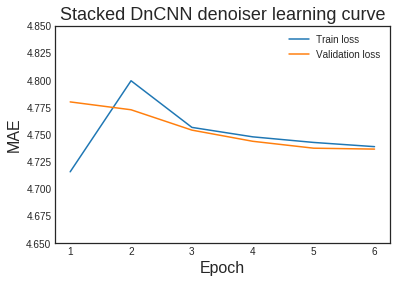

In [28]:
stacked_dcnn_loss = [[4.715741028150147], [4.799514106445151], [4.756613802086294], [4.7479170748144375], [4.742768291191498], [4.738893181415353]]
stacked_dcnn_val = [[4.7800538757654625], [4.772829051443285], [4.75410113145673], [4.743826312856099], [4.737480511803014], [4.736644077939311]]


plt.plot(np.arange(1,7),stacked_dcnn_loss)
plt.plot(np.arange(1,7),stacked_dcnn_val)
plt.ylim([4.65,4.85])

plt.title('Stacked DnCNN denoiser learning curve', fontsize = 18)
plt.ylabel('MAE', fontsize = 16)
plt.xlabel('Epoch', fontsize = 16)
plt.legend(['Train loss','Validation loss'])

### Save all

In [0]:
# Save all models
first_DnCNN.save('first_DcNN_hitrain_6e.h5')
!curl -F "file=@first_DcNN_hitrain_6e.h5" https://file.io
  
first_DnCNN.save('second_DcNN_hitrain_6e.h5')
!curl -F "file=@second_DcNN_hitrain_6e.h5" https://file.io
  
stacked_DnCNN.save('Stacked_DcNN_hitrain_6e.h5')
!curl -F "file=@Stacked_DcNN_hitrain_6e.h5" https://file.io


{"success":true,"key":"iwje7t","link":"https://file.io/iwje7t","expiry":"14 days"}{"success":true,"key":"1lQ1sW","link":"https://file.io/1lQ1sW","expiry":"14 days"}{"success":true,"key":"FUB6pd","link":"https://file.io/FUB6pd","expiry":"14 days"}

In [0]:
# Import trained shallow DnCNN
first_DnCNN = keras.models.load_model('./first_DcNN_hitrain_6e.h5')
first_DnCNN.name = 'first_DnCNN'

for lr in first_DnCNN.layers:
  lr.name = '1st_DcNN_'+lr.name

# Import second shallow trainable DnCNN
second_DnCNN = keras.models.load_model('./second_DcNN_hitrain_6e.h5')
for lr in second_DnCNN.layers:
  lr.name = '2nd_DcNN_'+lr.name
second_DnCNN.name = 'second_DnCNN'
  
hard_noise_input = Input((32,32,1))
denoised1 = first_DnCNN(hard_noise_input)
re_denoised = second_DnCNN(denoised1)

stacked_DnCNN = Model(hard_noise_input, re_denoised)
stacked_DnCNN.compile(optimizer='Adagrad', loss='mean_absolute_error')